In [1]:
%xmode verbose

Exception reporting mode: Verbose


In [2]:
!pip install statsforecast -q
!pip install neuralforecast -q
!pip install datasetsforecast -q
!pip install darts -q
!pip install sktime==0.17.0
!pip install pycaret -q
# !pip install prophet -q
# !pip install MissForest -q
# !pip install pycaret -q

# !pip install pytest -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 55.7 MB/s eta 0:00:0000:0100:01


# Faktor yang mempengaruhi Data Emas

In Indonesia, the factors that can impact the gold price are:

1. Supply and demand: The relationship between the supply of and demand for gold is a key factor affecting its price.
2. Economic conditions: Economic conditions in Indonesia, such as inflation, recession, and interest rates, can affect the demand for gold and thus its price.
3. Political stability: Political stability and uncertainty in Indonesia can impact the demand for gold as a safe haven asset and thereby affect its price.
4. Currency fluctuations: Changes in the value of the Indonesian Rupiah against other major currencies can impact the price of gold.
5. Mining and production costs: The cost of mining and producing gold in Indonesia can impact its price.
6. Jewelry demand: The demand for gold in the jewelry industry can impact its price.
7. Technology demand: The demand for gold in technology applications can impact its price.
8. Central bank buying and selling: Central bank activities, such as buying and selling gold, can impact its price.

Reference:

KPMG. (2018). The gold market: A review of the supply chain, demand, and pricing. In KPMG International (Ed.), Global Precious Metals Handbook 2018 (pp. 12-24). KPMG International.
Torgler, B. (2017). Gold demand, supply, and price dynamics: A macroeconomic analysis. In Gold Demand, Supply and Price Dynamics (pp. 1-23). Emerald Publishing Limited.
Buiter, W. H. (2012). The economics of gold. Handbook of Commodity Markets and Investment (pp. 557-592). Springer.

# Persiapan Dataset

In [3]:
from prophet import Prophet
from statsmodels.tsa.stattools import grangercausalitytests
from statsforecast.adapters.prophet import AutoARIMAProphet

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
%matplotlib inline

In [5]:
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('pystan').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('statsmodels').setLevel(logging.CRITICAL)

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.base.model")
warnings.filterwarnings("ignore")

## Fungsi Tambahan

In [6]:
from datasetsforecast.losses import mse, mae, rmse

def eva_cro_val_sf(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [7]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_matrix(data, variables, maxlag, test='ssr_chi2test'):
    """
    This function returns two dataframes with results of granger causality tests for all pairs of variables.
    
    Parameters:
        data (DataFrame): The input data, containing all variables in the form of a time series.
        variables (list): List of all the variables to be tested.
        maxlag (int): Maximum number of lags to test.
        test (str): Test statistic to use (default is 'ssr_chi2test').
    
    Returns:
        tuple: Two dataframes, the first one contains the minimum lags where causality is found, and the second one contains the p-values at those lags.
    """
    num_vars = len(variables) # Number of variables
    df1 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    df2 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    
    # Loop through all variable combinations
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            result = None
            try:
                result = grangercausalitytests(data[[variables[i], variables[j]]], maxlag=maxlag, verbose=False)
                p_values = [round(result[lag][0][test][1], 10) for lag in range(1, maxlag+1)]
                min_lag = np.argmin(p_values)
                if min_lag == maxlag - 1 and p_values[min_lag] >= 0.05:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
                else:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = int(min_lag+1)
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = p_values[min_lag]
            except:
                df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
    return df1.T, df2.T

In [8]:
import statsmodels.api as sm

def make_stationary(data, max_diff = 10):
    """
    This function will return the stationary time series after difference has been applied and the number of differences applied.
    The input data should be a one-dimensional numpy array or pandas series.
    
    Parameters:
    data (numpy array or pandas series): The time series data that needs to be made stationary.
    max_diff (int, optional): The maximum number of differences to be applied. Defaults to 10.
    
    Returns:
    tuple: A tuple contains the stationary time series and the number of differences applied.
    """
    diff = 0
    result = sm.tsa.stattools.adfuller(data)
    while result[1] >= 0.05 and diff < max_diff:
        data = np.diff(data)
        result = sm.tsa.stattools.adfuller(data)
        diff += 1
    return data, diff


In [9]:
import pandas as pd

def date_to_ym(date_series):
    """
    Convert a pandas series of datetime dates into a series of strings in the format "YYYY-MM".
    
    Parameters:
        date_series (pd.Series): A pandas series of datetime dates.
    
    Returns:
        pd.Series: A pandas series of strings in the format "YYYY-MM".
    """
    datetime_series = pd.to_datetime(date_series)
    ym_series = datetime_series.dt.strftime("%Y-%m")
    return ym_series

In [10]:
from datetime import datetime

def indonesian_month_to_date(month_string_year_int):
    month_dict = {
        'Januari': '01',
        'Februari': '02',
        'Maret': '03',
        'April': '04',
        'Mei': '05',
        'Juni': '06',
        'Juli': '07',
        'Agustus': '08',
        'September': '09',
        'Oktober': '10',
        'November': '11',
        'Desember': '12'
    }
    split_string = month_string_year_int.split(" ")
    month = month_dict[split_string[0]]
    year = split_string[1]
    date_str = f"{year}-{month}"
    return date_str

In [11]:
def string_to_date_indo(date_string):
    """
    This function takes a date string in the format "dd month_name yyyy"
    (with support for Indonesian month names) and returns a datetime.date object.
    """
    
    # Dictionary to map Indonesian month names to English month names
    indonesian_months = {
        "Januari": "January",
        "Februari": "February",
        "Maret": "March",
        "April": "April",
        "Mei": "May",
        "Juni": "June",
        "Juli": "July",
        "Agustus": "August",
        "September": "September",
        "Oktober": "October",
        "November": "November",
        "Desember": "December"
    }
    
    # Replace the Indonesian month name in the input date_string with the corresponding English month name
    date_string = date_string.replace(date_string.split(" ")[1], indonesian_months[date_string.split(" ")[1]])
    
    # Parse the input date_string into a datetime.date object
    date_object = datetime.strptime(date_string, "%d %B %Y").date()
    
    # Return the datetime.date object
    return date_object

In [12]:
var_inter_model = {'tanggal':'ds',
                    'harga_emas':'y',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

var_model_inter = {'ds':'tanggal',
                    'y':'harga_emas',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

## Data Emas 

In [13]:
import numpy as np
import pandas as pd
from datetime import date, timedelta

In [14]:
from datetime import datetime as dtime


direc = "/kaggle/input/data-emas-skripsi/Data_emas/"

tabel_emas         = pd.read_json(direc + 'data_emas.json')
tabel_emas.columns = ['tanggal','harga_emas']
# tabel_emas.tanggal
tabel_emas.tanggal = pd.to_datetime(tabel_emas.tanggal,unit='ms').dt.date

enddate = pd.to_datetime('2023-02-01').date()
tabel_emas = tabel_emas.loc[tabel_emas.tanggal < enddate]
tabel_emas = tabel_emas.iloc[tabel_emas.tanggal.drop_duplicates().index.tolist(),:]
tabel_emas = tabel_emas.reset_index(drop=True)
tabel_emas.tail(10)

,tanggal,harga_emas
3739,2023-01-22,1035000
3740,2023-01-23,1035000
3741,2023-01-24,1037000
3742,2023-01-25,1040000
3743,2023-01-26,1035000
3744,2023-01-27,1030000
3745,2023-01-28,1029000
3746,2023-01-29,1029000
3747,2023-01-30,1029000
3748,2023-01-31,1027000


## Data Kurs Dolar Ke Rupiah
* https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx


In [15]:
# data 
# https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx

data_kurs = pd.read_excel(direc + 'Kurs Transaksi USD.xlsx',skiprows=4)
data_kurs = data_kurs.drop(['NO','Nilai'],axis=1)
data_kurs.Tanggal = pd.to_datetime(data_kurs.Tanggal,format='%m/%d/%Y %I:%M:%S %p')
data_kurs.Tanggal = data_kurs.Tanggal.dt.date
data_kurs.head(20)

,Kurs Jual,Kurs Beli,Tanggal
0,15053.90,14904.10,2023-01-31
1,15052.89,14903.11,2023-01-30
2,15038.82,14889.18,2023-01-27
3,15032.79,14883.21,2023-01-26
4,15004.65,14855.35,2023-01-25
5,15196.60,15045.40,2023-01-24
6,15188.57,15037.43,2023-01-20
7,15212.68,15061.32,2023-01-19
8,15229.77,15078.23,2023-01-18
9,15094.09,14943.91,2023-01-17


In [16]:
tabel_emas_kurs = pd.merge(tabel_emas, data_kurs,
                           how='left',
                           left_on='tanggal',
                           right_on='Tanggal')
tabel_emas_kurs = tabel_emas_kurs.drop(['Tanggal'],axis=1)
tabel_emas_kurs["month_year"] = date_to_ym(tabel_emas_kurs.tanggal)
tabel_emas_kurs

,tanggal,harga_emas,Kurs Jual,Kurs Beli,month_year
0,2010-01-04,408000,9377.00,9283.00,2010-01
1,2010-01-05,410000,9355.00,9261.00,2010-01
2,2010-01-06,410000,9355.00,9261.00,2010-01
3,2010-01-07,412000,9274.00,9182.00,2010-01
4,2010-01-08,410000,9286.00,9194.00,2010-01
...,...,...,...,...,...
3744,2023-01-27,1030000,15038.82,14889.18,2023-01
3745,2023-01-28,1029000,NaN,NaN,2023-01
3746,2023-01-29,1029000,NaN,NaN,2023-01
3747,2023-01-30,1029000,15052.89,14903.11,2023-01


In [17]:
tabel_emas_kurs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tanggal     3749 non-null   object 
 1   harga_emas  3749 non-null   int64  
 2   Kurs Jual   3203 non-null   float64
 3   Kurs Beli   3203 non-null   float64
 4   month_year  3749 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 175.7+ KB


## Data Inflasi
* https://www.bi.go.id/en/statistik/indikator/data-inflasi.aspx

In [18]:
data_inflasi = pd.read_excel(direc+"Data Inflasi.xlsx",skiprows=4)
data_inflasi = data_inflasi.iloc[:,:3]
data_inflasi = data_inflasi.drop('No',axis=1)
data_inflasi.Period = data_inflasi.Period.apply(lambda x: indonesian_month_to_date(x))
data_inflasi["Inflation Data"] = data_inflasi["Inflation Data"].apply(lambda x: float(x.split()[0])/100)
data_inflasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          157 non-null    object 
 1   Inflation Data  157 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [19]:
tabel_emas_kurs_inflasi = tabel_emas_kurs.merge(data_inflasi,left_on="month_year",
                                                right_on="Period",how='left')
tabel_emas_kurs_inflasi = tabel_emas_kurs_inflasi.drop(['Period'],axis=1)
print(tabel_emas_kurs_inflasi.shape)
tabel_emas_kurs_inflasi

(3749, 6)


,tanggal,harga_emas,Kurs Jual,Kurs Beli,month_year,Inflation Data
0,2010-01-04,408000,9377.00,9283.00,2010-01,0.0372
1,2010-01-05,410000,9355.00,9261.00,2010-01,0.0372
2,2010-01-06,410000,9355.00,9261.00,2010-01,0.0372
3,2010-01-07,412000,9274.00,9182.00,2010-01,0.0372
4,2010-01-08,410000,9286.00,9194.00,2010-01,0.0372
...,...,...,...,...,...,...
3744,2023-01-27,1030000,15038.82,14889.18,2023-01,0.0528
3745,2023-01-28,1029000,NaN,NaN,2023-01,0.0528
3746,2023-01-29,1029000,NaN,NaN,2023-01,0.0528
3747,2023-01-30,1029000,15052.89,14903.11,2023-01,0.0528


## Data Suku Bunga
* https://www.bi.go.id/id/statistik/indikator/bi-7day-rr.aspx
* BI 7-day (Reverse) Repo Rate

In [20]:
suku_bunga_df_jan_2023 = pd.read_excel(direc+'Interest_Rate_Januari_2023.xlsx',skiprows=4)
suku_bunga_df_jan_2023 = suku_bunga_df_jan_2023.iloc[:,1:3]
suku_bunga_df_jan_2023.Tanggal = suku_bunga_df_jan_2023.Tanggal.apply(lambda x: indonesian_month_to_date(x.split()[1] + ' ' + x.split()[2]))
suku_bunga_df_jan_2023['BI-7Day-RR'] = suku_bunga_df_jan_2023['BI-7Day-RR'].apply(lambda x : float(x.split()[0]))
suku_bunga_df_jan_2023.columns = ['date_month_indo','suku_bunga_bi']
suku_bunga_df_jan_2023

,date_month_indo,suku_bunga_bi
0,2023-01,5.75


In [21]:
suku_bunga_df = pd.read_csv(direc+'Interest Rate.csv',delimiter=";")

suku_bunga_df = suku_bunga_df.drop(['nama_item_vertical_variabel','nama_variabel_turunan'],axis=1)
suku_bunga_df = suku_bunga_df.iloc[:,1:]


suku_bunga_df['date_month'] = suku_bunga_df['nama_turunan_tahun'] + ' ' + suku_bunga_df['nama_tahun'].astype('string')
suku_bunga_df = suku_bunga_df[['date_month','data_content']]
suku_bunga_df = suku_bunga_df.rename(columns= {'date_month':'date_month','data_content':'suku_bunga_bi'})
suku_bunga_df['date_month_indo'] = suku_bunga_df['date_month'].apply(lambda x : indonesian_month_to_date(x))
suku_bunga_df = suku_bunga_df[['date_month_indo','suku_bunga_bi']]
suku_bunga_df = pd.concat([suku_bunga_df,suku_bunga_df_jan_2023],axis=0)

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi.merge(suku_bunga_df,
                                                                left_on="month_year",
                                                                right_on="date_month_indo",how='left')

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest.drop(['month_year','date_month_indo'],axis=1)
tabel_emas_kurs_inflasi_interest.columns = ['tanggal','harga_emas','kurs_jual','kurs_beli','data_inflasi','suku_bunga_bi']
tabel_emas_kurs_inflasi_interest

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.00,9283.00,0.0372,6.50
1,2010-01-05,410000,9355.00,9261.00,0.0372,6.50
2,2010-01-06,410000,9355.00,9261.00,0.0372,6.50
3,2010-01-07,412000,9274.00,9182.00,0.0372,6.50
4,2010-01-08,410000,9286.00,9194.00,0.0372,6.50
...,...,...,...,...,...,...
3744,2023-01-27,1030000,15038.82,14889.18,0.0528,5.75
3745,2023-01-28,1029000,NaN,NaN,0.0528,5.75
3746,2023-01-29,1029000,NaN,NaN,0.0528,5.75
3747,2023-01-30,1029000,15052.89,14903.11,0.0528,5.75


In [22]:
tabel_emas_kurs_inflasi_interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tanggal        3749 non-null   object 
 1   harga_emas     3749 non-null   int64  
 2   kurs_jual      3203 non-null   float64
 3   kurs_beli      3203 non-null   float64
 4   data_inflasi   3749 non-null   float64
 5   suku_bunga_bi  3749 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 205.0+ KB


## Data Covid 19

* Data Bersumber dari OWID [Github OWID data](https://github.com/owid/covid-19-data/tree/master/public/data)

In [23]:
tabel_emas_kurs_inflasi_interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tanggal        3749 non-null   object 
 1   harga_emas     3749 non-null   int64  
 2   kurs_jual      3203 non-null   float64
 3   kurs_beli      3203 non-null   float64
 4   data_inflasi   3749 non-null   float64
 5   suku_bunga_bi  3749 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 205.0+ KB


In [24]:
covid_df = pd.read_csv('/kaggle/input/data-emas-skripsi/Data_emas/owid-covid-data.csv')
covid_df = covid_df[covid_df.location == 'Indonesia']
covid_df = covid_df[['date','new_cases','new_deaths']]
covid_df

,date,new_cases,new_deaths
123316,2020-01-03,0.0,0.0
123317,2020-01-04,0.0,0.0
123318,2020-01-05,0.0,0.0
123319,2020-01-06,0.0,0.0
123320,2020-01-07,0.0,0.0
...,...,...,...
124521,2023-04-22,752.0,6.0
124522,2023-04-23,384.0,1.0
124523,2023-04-24,620.0,5.0
124524,2023-04-25,1167.0,8.0


In [25]:
from datetime import datetime as dtdt
covid_df.date = covid_df.date.apply(lambda x: dtdt.strptime(x, '%Y-%m-%d').date())
covid_df.date

123316    2020-01-03
123317    2020-01-04
123318    2020-01-05
123319    2020-01-06
123320    2020-01-07
             ...    
124521    2023-04-22
124522    2023-04-23
124523    2023-04-24
124524    2023-04-25
124525    2023-04-26
Name: date, Length: 1210, dtype: object

In [26]:
tabel_emas_kurs_inflasi_interest_covid = pd.merge(tabel_emas_kurs_inflasi_interest,
                                                 covid_df,how='left',
                                                  left_on='tanggal',
                                                  right_on='date'
                                                 )

In [27]:
tabel_emas_kurs_inflasi_interest_covid = tabel_emas_kurs_inflasi_interest_covid.drop(['date'],axis=1)
tabel_emas_kurs_inflasi_interest_covid.new_cases = tabel_emas_kurs_inflasi_interest_covid.new_cases.fillna(0)
tabel_emas_kurs_inflasi_interest_covid.new_deaths = tabel_emas_kurs_inflasi_interest_covid.new_deaths.fillna(0)
tabel_emas_kurs_inflasi_interest_covid.shape

(3749, 8)

In [28]:
tabel_emas_kurs_inflasi_interest_covid.to_csv('Tabel_Emas_Ext.csv',index=False)

In [29]:
tabel_emas_kurs_inflasi_interest

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.00,9283.00,0.0372,6.50
1,2010-01-05,410000,9355.00,9261.00,0.0372,6.50
2,2010-01-06,410000,9355.00,9261.00,0.0372,6.50
3,2010-01-07,412000,9274.00,9182.00,0.0372,6.50
4,2010-01-08,410000,9286.00,9194.00,0.0372,6.50
...,...,...,...,...,...,...
3744,2023-01-27,1030000,15038.82,14889.18,0.0528,5.75
3745,2023-01-28,1029000,NaN,NaN,0.0528,5.75
3746,2023-01-29,1029000,NaN,NaN,0.0528,5.75
3747,2023-01-30,1029000,15052.89,14903.11,0.0528,5.75


In [30]:
tabel_emas_kurs_inflasi_interest_covid.isna().sum()

tanggal            0
harga_emas         0
kurs_jual        546
kurs_beli        546
data_inflasi       0
suku_bunga_bi      0
new_cases          0
new_deaths         0
dtype: int64

In [31]:
from IPython.display import display
display(tabel_emas_kurs_inflasi_interest_covid.info())
tabel_emas_kurs_inflasi_interest_covid_no_tanggal =  tabel_emas_kurs_inflasi_interest_covid.drop(['tanggal'],
                                                                                                 axis=1)
display(tabel_emas_kurs_inflasi_interest_covid_no_tanggal)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tanggal        3749 non-null   object 
 1   harga_emas     3749 non-null   int64  
 2   kurs_jual      3203 non-null   float64
 3   kurs_beli      3203 non-null   float64
 4   data_inflasi   3749 non-null   float64
 5   suku_bunga_bi  3749 non-null   float64
 6   new_cases      3749 non-null   float64
 7   new_deaths     3749 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 263.6+ KB


None

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
0,408000,9377.00,9283.00,0.0372,6.50,0.0,0.0
1,410000,9355.00,9261.00,0.0372,6.50,0.0,0.0
2,410000,9355.00,9261.00,0.0372,6.50,0.0,0.0
3,412000,9274.00,9182.00,0.0372,6.50,0.0,0.0
4,410000,9286.00,9194.00,0.0372,6.50,0.0,0.0
...,...,...,...,...,...,...,...
3744,1030000,15038.82,14889.18,0.0528,5.75,211.0,2.0
3745,1029000,NaN,NaN,0.0528,5.75,199.0,1.0
3746,1029000,NaN,NaN,0.0528,5.75,165.0,1.0
3747,1029000,15052.89,14903.11,0.0528,5.75,183.0,7.0


In [32]:
from sklearn.impute import KNNImputer

knnimp = KNNImputer()
col_no_tang = tabel_emas_kurs_inflasi_interest_covid_no_tanggal.columns.tolist()
print(col_no_tang)
tabel_emas_kurs_inflasi_interest_covid_no_tanggal = knnimp.fit_transform(tabel_emas_kurs_inflasi_interest_covid_no_tanggal)
tabel_emas_kurs_inflasi_interest_covid_no_tanggal = pd.DataFrame(tabel_emas_kurs_inflasi_interest_covid_no_tanggal,
                                                                 columns=col_no_tang)
tabel_emas_kurs_inflasi_interest_covid[col_no_tang] = tabel_emas_kurs_inflasi_interest_covid_no_tanggal
tabel_emas_kurs_inflasi_interest_covid.isna().sum()

['harga_emas', 'kurs_jual', 'kurs_beli', 'data_inflasi', 'suku_bunga_bi', 'new_cases', 'new_deaths']


tanggal          0
harga_emas       0
kurs_jual        0
kurs_beli        0
data_inflasi     0
suku_bunga_bi    0
new_cases        0
new_deaths       0
dtype: int64

## Plot Data

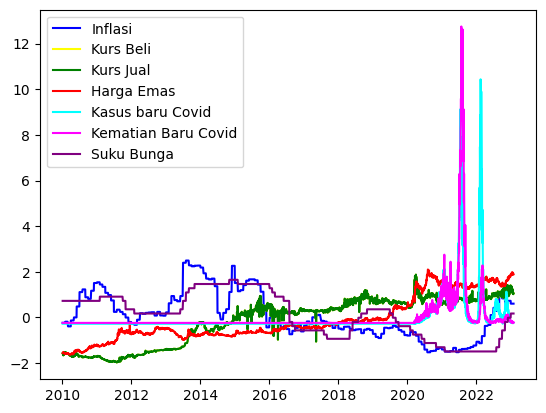

In [33]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()

fig, ax = plt.subplots()
# standardisasi agar bisa melihat apa pengarhus diantara keduanya
ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["data_inflasi"]]),
        label="Inflasi",color="blue")

ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["kurs_beli"]]),
        label="Kurs Beli",color="yellow")

ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["kurs_jual"]]),
        label="Kurs Jual",color="green")

ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["harga_emas"]]),
        label="Harga Emas",color="red")

ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["new_cases"]]),
        label="Kasus baru Covid",color="cyan")

ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["new_deaths"]]),
        label="Kematian Baru Covid",color="magenta")

ax.plot(tabel_emas_kurs_inflasi_interest_covid.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest_covid[["suku_bunga_bi"]]),
        label="Suku Bunga",color="purple")

plt.legend()
plt.show()

Ada Beberapa kesimpulan dari grafik ini
* Ada pengaruh antara Harga Emas dan Kurs Jual
* Ada Pengaruh antara harga emas dan inflasi pada tahun 2010 hingga 2017
* Tetapi, ada hal yang berpengaruh negatif pada inflasi dari 2017 hingga januari 2022
* kemunkinan kurang berpengaruh antara inflasi dengan kurs jual
* kurs jual dan kurs beli memiliki kesamaan grafik , maka mereka cenderung menyatu

## Plot Norm

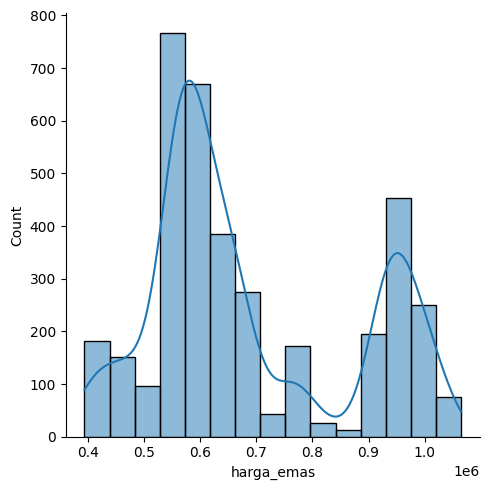

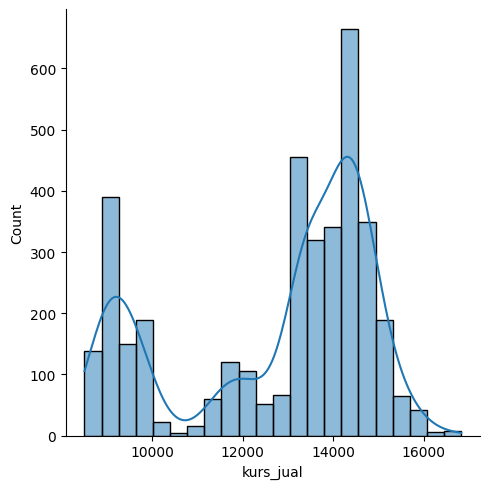

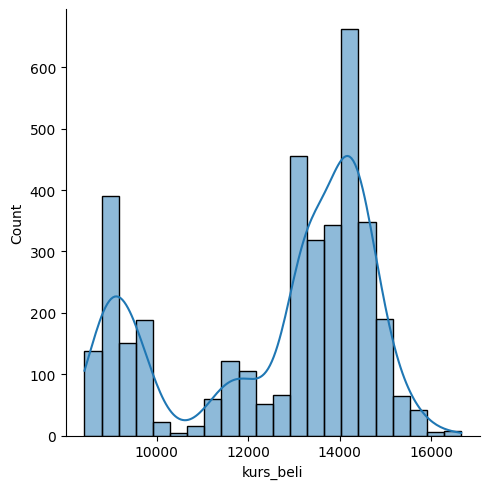

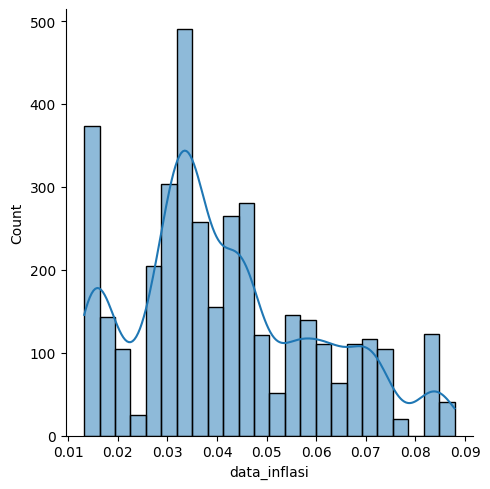

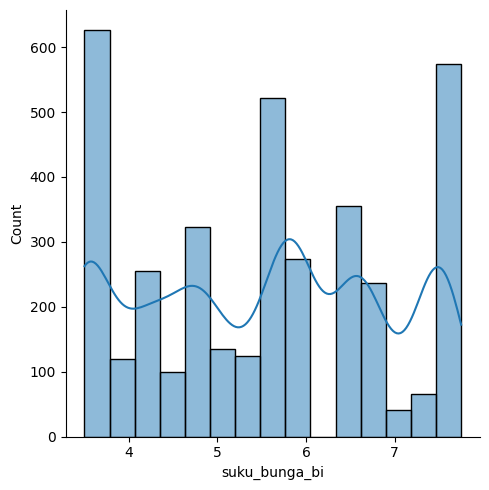

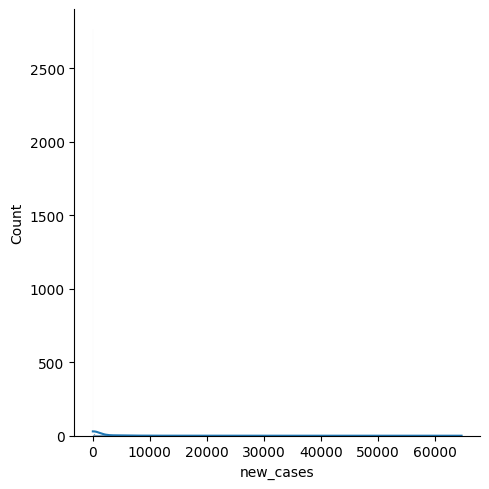

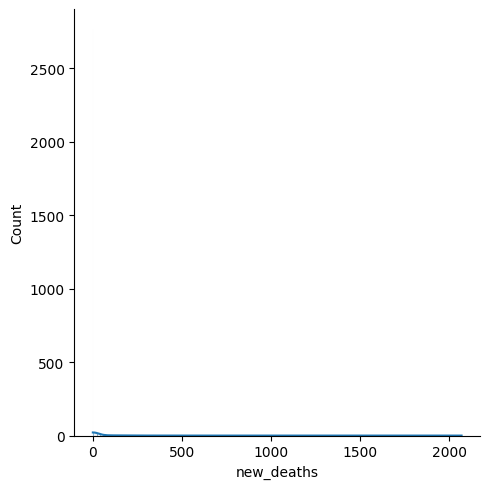

In [34]:
import seaborn as sns
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="harga_emas", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="kurs_jual", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="kurs_beli", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="data_inflasi", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="suku_bunga_bi", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="new_cases", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest_covid, x="new_deaths", kde=True)

### Sebaran Data
* Harga Emas memiliki distribusi Bimodal
* Kurs Beli Dollar memiliki distribusi Bimodal
* Kurs Jual Dollar memiliki distribusi Bimodal
* Data Inflasi cenderung memiliki distribusi normal
* Suku Bunga BI cenderung mendekati distribusi banyak modal

## Stationary Analysis

In [35]:
min_lag_df,test_result_lag  = granger_causality_matrix(tabel_emas_kurs_inflasi_interest_covid,
                                        tabel_emas_kurs_inflasi_interest_covid.drop('tanggal',axis=1).columns.tolist(),
                                        maxlag=100)
print(f'min_lag_df\n{min_lag_df}\n')
print(f'test_result_lag\n{test_result_lag}')
# 2menit

min_lag_df
                 harga_emas_x  kurs_jual_x  kurs_beli_x  data_inflasi_x  \
harga_emas_y              0.0          0.0          0.0             0.0   
kurs_jual_y               4.0          0.0          0.0             0.0   
kurs_beli_y               4.0         15.0          0.0             0.0   
data_inflasi_y           55.0         97.0         97.0             0.0   
suku_bunga_bi_y          56.0          1.0          1.0             1.0   
new_cases_y              41.0         68.0         68.0             2.0   
new_deaths_y             99.0          1.0          1.0             1.0   

                 suku_bunga_bi_x  new_cases_x  new_deaths_x  
harga_emas_y                 0.0          0.0           0.0  
kurs_jual_y                  0.0          0.0           0.0  
kurs_beli_y                  0.0          0.0           0.0  
data_inflasi_y               0.0          0.0           0.0  
suku_bunga_bi_y              0.0          0.0           0.0  
new_cases_y     

In [36]:
from statsmodels.tsa.stattools import pacf,acf
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# pacfku = pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=1648)
acfku = acf(tabel_emas_kurs_inflasi_interest_covid['harga_emas'],nlags=3298)

data_acf = pd.DataFrame({'acf':acfku})
print(data_acf.sort_values('acf')[2174:2176])

# percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
# result = seasonal_decompose(percobaan)
# result

           acf
1124  0.059477
1123  0.059974


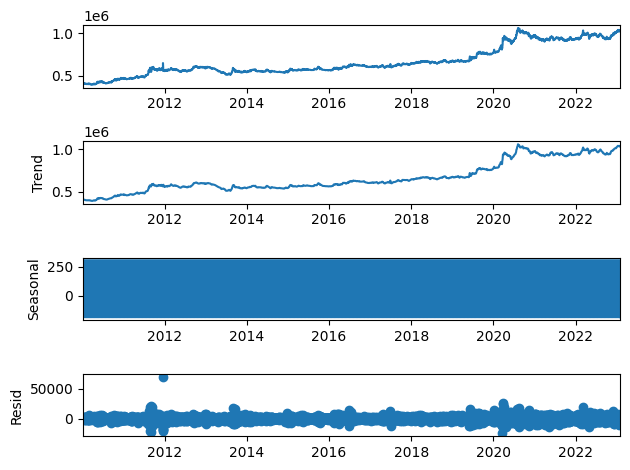

In [37]:
percobaan = tabel_emas_kurs_inflasi_interest_covid[['tanggal','harga_emas']]
percobaan.tanggal = pd.to_datetime(percobaan.tanggal)
percobaan = percobaan.set_index('tanggal')
percobaan = percobaan.asfreq('B')
percobaan = percobaan.interpolate(method='spline',order=5,axis=0)
result = seasonal_decompose(percobaan,)
result.plot()
plt.show()

Index(['ds', 'AutoARIMA', 'AutoETS', 'HoltWinters', 'HistoricAverage', 'CES',
       'AutoTheta'],
      dtype='object')


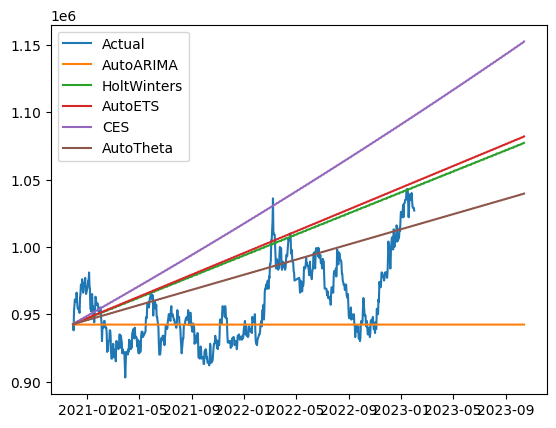

In [38]:
from statsforecast.models import (       
        MSTL,
        AutoARIMA,
        AutoETS,
        HoltWinters,
        HistoricAverage,
        AutoCES,
        AutoTheta,
)
from statsforecast import StatsForecast

from neuralforecast.auto import AutoNHITS


tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_kurs_inflasi_interest_uniq['unique_id'] = 0
tabel_emas_kurs_inflasi_interest_uniq['ds'] = tabel_emas_kurs_inflasi_interest_uniq['tanggal']
tabel_emas_kurs_inflasi_interest_uniq['y'] = tabel_emas_kurs_inflasi_interest_uniq['harga_emas']
tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest_uniq.drop(['harga_emas','tanggal'],axis=1)

cobain = tabel_emas_kurs_inflasi_interest_uniq[['unique_id','ds','y']]


y_train = cobain[:int(len(cobain)*0.8)]
y_test = cobain[int(len(cobain)*0.8):]

modelan = StatsForecast(models=[AutoARIMA(),
                                AutoETS(),
                                HoltWinters(season_length=7),
                                HistoricAverage(),
                                AutoCES(),
                                AutoTheta(),
                                ],
                        freq='B')

modelan.fit(df=y_train)
y_predict = modelan.predict(h=len(y_test))

print(y_predict.columns)

plt.plot(y_test.ds,y_test.y,label='Actual')
plt.plot(y_predict.ds,y_predict.AutoARIMA,label='AutoARIMA')
plt.plot(y_predict.ds,y_predict.HoltWinters  ,label='HoltWinters')
plt.plot(y_predict.ds,y_predict.AutoETS  ,label='AutoETS')
plt.plot(y_predict.ds,y_predict.CES  ,label='CES')
plt.plot(y_predict.ds,y_predict.AutoTheta  ,label='AutoTheta')

plt.legend()
plt.show()

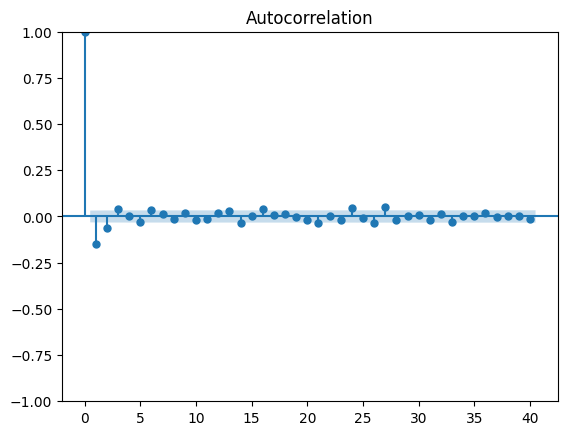

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=3298)
plot_acf(tabel_emas_kurs_inflasi_interest_covid['harga_emas'].diff(periods=1).dropna(),lags=40)
plt.show()

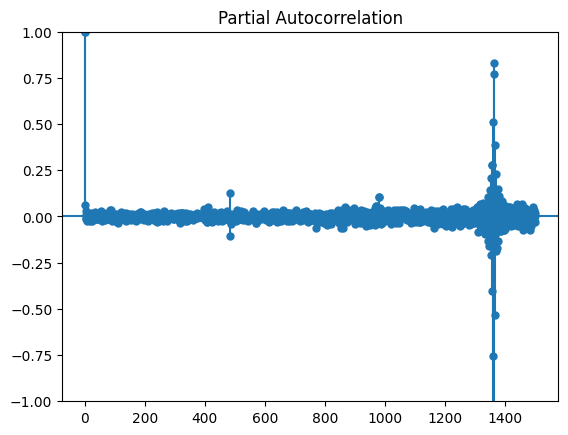

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(tabel_emas_kurs_inflasi_interest_covid['harga_emas'],lags=1500)
plt.show()

In [41]:
from statsforecast.adapters.prophet import AutoARIMAProphet

In [42]:
model_arprophet = AutoARIMAProphet()
tabel_emas_arpr = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_arpr.tanggal = pd.to_datetime(tabel_emas_arpr.tanggal)
tabel_emas_arpr.tanggal = tabel_emas_arpr.tanggal.dt.to_period('B')
tabel_emas_arpr = tabel_emas_arpr.drop_duplicates('tanggal')
tabel_emas_arpr = tabel_emas_arpr.set_index('tanggal')

idx = pd.period_range(min(tabel_emas_arpr.index), max(tabel_emas_arpr.index))
tabel_emas_arpr = tabel_emas_arpr.reindex(idx, fill_value=np.nan)
tabel_emas_arpr = tabel_emas_arpr.reset_index()
tabel_emas_arpr = tabel_emas_arpr[['index','harga_emas']]
tabel_emas_arpr.columns = ['ds','y']
tabel_emas_arpr.ds = pd.to_datetime(tabel_emas_arpr.ds.astype(str))

In [43]:
model_arprophet.add_country_holidays('ID')
model_arprophet.fit(tabel_emas_arpr)

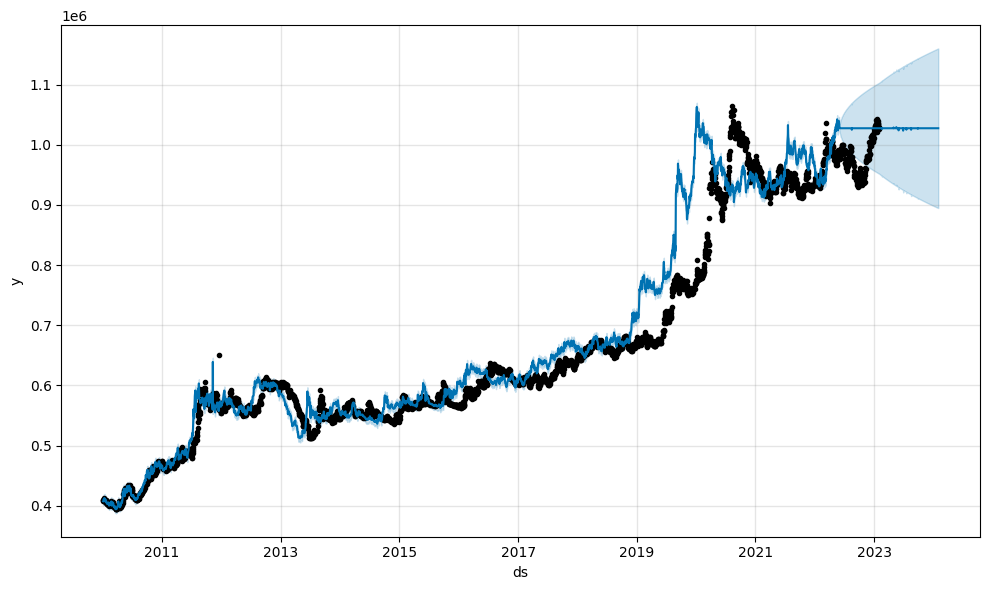

In [44]:
future = model_arprophet.make_future_dataframe(365)
forecast = model_arprophet.predict(future)
fig = model_arprophet.plot(forecast)

# Pycaret

In [45]:
model_pakai_ts = ['naive', 'grand_means', 'snaive', 'prophet', 'lr_cds_dt','arima','auto_arima',
               'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'lar_cds_dt',
               'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'par_cds_dt', 
               'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt','et_cds_dt',
               'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 
               'catboost_cds_dt']

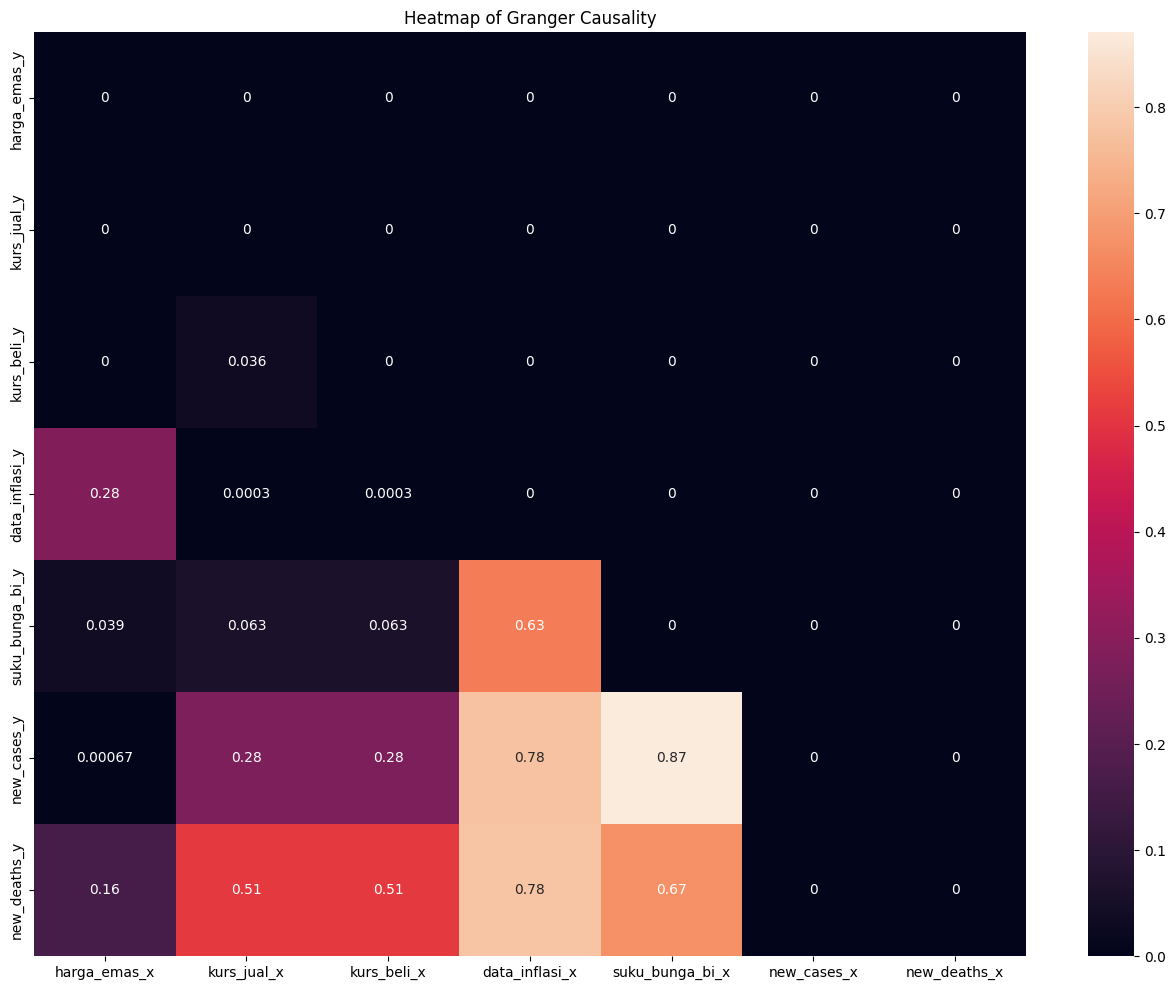

In [46]:
plt.figure(figsize=(16, 12))
sns.heatmap(test_result_lag,
            annot=True,
           ).set(title='Heatmap of Granger Causality')
plt.savefig('Heatmap of Granger Causality.png')

In [47]:
tabel_emas_kurs_inflasi_interest_covid.describe()

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
count,3.749000e+03,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000
mean,6.881367e+05,12773.132856,12645.998817,0.041617,5.520605,1679.126167,38.429181
std,1.795539e+05,2161.207336,2139.711723,0.018575,1.353207,6041.313010,159.254579
min,3.940000e+05,8502.000000,8418.000000,0.013200,3.500000,0.000000,0.000000
25%,5.660000e+05,11411.000000,11297.000000,0.030000,4.250000,0.000000,0.000000
50%,6.190000e+05,13534.000000,13400.000000,0.037200,5.750000,0.000000,0.000000
75%,9.140000e+05,14398.640000,14255.370000,0.054700,6.500000,218.000000,4.000000
max,1.065000e+06,16824.710000,16657.300000,0.087900,7.750000,64718.000000,2069.000000


## Pycaret Uni

In [48]:
from pycaret.time_series import *

tabel_emas_pycaret = tabel_emas.copy()
tabel_emas_pycaret.tanggal = pd.to_datetime(tabel_emas_pycaret.tanggal)
tabel_emas_pycaret.tanggal = tabel_emas_pycaret.tanggal.dt.to_period('B')
tabel_emas_pycaret = tabel_emas_pycaret.drop_duplicates('tanggal')
tabel_emas_pycaret = tabel_emas_pycaret.set_index('tanggal')

idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)

pycaret_time_series = TSForecastingExperiment()
pycaret_time_series.setup(data=tabel_emas_pycaret,
            target='harga_emas',
            numeric_imputation_target='drift',
            # max_sp_to_consider=None,
            # num_sps_to_use=-1,
            transform_target="box-cox",
            fold=2,
            fh=730,
            session_id=42)
pycaret_time_series.check_stats()

,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,5.1%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1.497429
3,Summary,Statistics,Transformed,Median,,1.497423
4,Summary,Statistics,Transformed,Standard Deviation,,0.000032
5,Summary,Statistics,Transformed,Variance,,0.0
6,Summary,Statistics,Transformed,Kurtosis,,-0.500866
7,Summary,Statistics,Transformed,Skewness,,0.033281
8,Summary,Statistics,Transformed,# Distinct Values,,728.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",77862.937532


In [49]:
tabel_emas_pycaret

,harga_emas
2010-01-04,408000.0
2010-01-05,410000.0
2010-01-06,410000.0
2010-01-07,412000.0
2010-01-08,410000.0
...,...
2023-01-25,1040000.0
2023-01-26,1035000.0
2023-01-27,1030000.0
2023-01-30,1029000.0


In [50]:
model_pycaret = pycaret_time_series.compare_models()
model_pycaret

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,3.2808,2.8375,32618.0753,46426.3148,0.0456,0.0482,0.0904,12.8500
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,3.4941,2.9571,34695.3267,48342.8735,0.0485,0.0514,0.0173,13.9000
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,3.8080,3.1108,37757.0020,50814.1248,0.0529,0.0562,-0.0825,24.6350
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,3.8568,3.1073,38162.2075,50669.4297,0.0535,0.0568,-0.0723,13.4800
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,3.8883,3.1413,38542.2075,51308.7603,0.0541,0.0575,-0.1034,24.4350
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,3.9321,3.1560,38974.9084,51550.9063,0.0548,0.0582,-0.1140,16.4950
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,3.9523,3.1695,39146.4237,51739.1946,0.0549,0.0584,-0.1202,16.2250
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,4.1498,3.2809,41414.8756,53829.0914,0.0594,0.0623,-0.2444,13.0750
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,4.1498,3.2809,41414.8756,53829.0914,0.0594,0.0623,-0.2444,13.1900
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,4.1498,3.2809,41414.8756,53829.0914,0.0594,0.0623,-0.2444,12.9650


Processing:   0%|          | 0/125 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [10, 9,
                                                                        8, 7, 6,
                                                                        5, 4, 3,
                                                                        2, 1]},
                                                   n_jobs=1)],
                    regressor=HuberRegressor(), sp=10)

In [51]:
best_model = pycaret_time_series.tune_model(model_pycaret)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-09-09,nan,nan,nan,nan,nan,nan,nan
1,2017-06-27,7.0011,5.8147,68119.9381,93110.7025,0.0916,0.0993,-1.1061
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.0min finished


In [52]:
pycaret_time_series.plot_model(model_pycaret)

In [53]:
pycaret_time_series.plot_model(model_pycaret,plot="decomp")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [54]:
pycaret_time_series.plot_model(model_pycaret,plot="decomp_stl")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [55]:
pycaret_time_series.plot_model(model_pycaret,plot="diagnostics")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [56]:
final_model = pycaret_time_series.finalize_model(best_model)
final_model

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42)),
                                                                                           ('transformer',
                                                                                            BoxCoxTransformer())])),
                                                               ('model',
                                                                BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [10,
                                                                                                                                        9,
                                                                                                                                        8,
                                                                                                                                        7,
                                                                                                                                        6,
                                                                                                                                        5,
                                                                                                                                        4,
                                                                                                                                        3,
                                                                                                                                        2,
                                                                                                                                        1]},
                                                                                                                   n_jobs=1)],
                                                                                    regressor=HuberRegressor(),
                                                                                    sp=10))]))])

<AxesSubplot: >

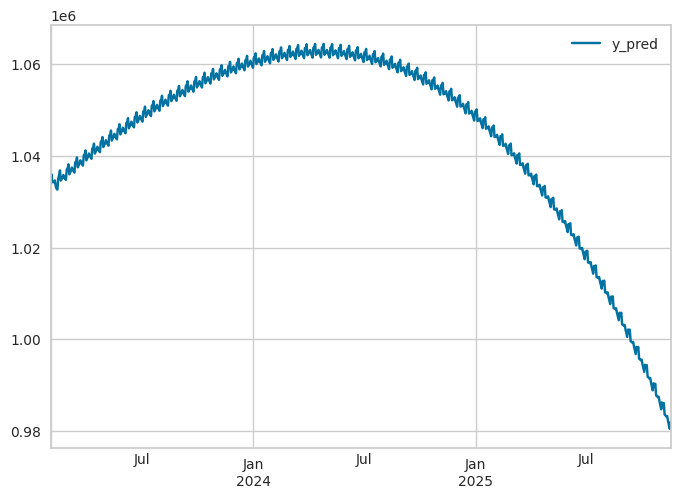

In [57]:
hasil_ts_uni = pycaret_time_series.predict_model(final_model,fh=730)
hasil_ts_uni.plot()

In [58]:
hasil_ts_uni.columns = ['harga_emas']
hasil_ts_uni.head(10)

,harga_emas
2023-02-01,1.033902e+06
2023-02-02,1.035962e+06
2023-02-03,1.034371e+06
2023-02-06,1.034217e+06
2023-02-07,1.034327e+06
2023-02-08,1.034643e+06
2023-02-09,1.033414e+06
2023-02-10,1.032847e+06
2023-02-13,1.032623e+06
2023-02-14,1.035058e+06


## Pycaret Prophet Uni

In [59]:
from pycaret.time_series import *

tabel_emas_pycaret = tabel_emas.copy()
tabel_emas_pycaret.tanggal = pd.to_datetime(tabel_emas_pycaret.tanggal)
tabel_emas_pycaret.tanggal = tabel_emas_pycaret.tanggal.dt.to_period('B')
tabel_emas_pycaret = tabel_emas_pycaret.drop_duplicates('tanggal')
tabel_emas_pycaret = tabel_emas_pycaret.set_index('tanggal')

idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)

pycaret_prophet = TSForecastingExperiment()
pycaret_prophet.setup(data=tabel_emas_pycaret,
            target='harga_emas',
            numeric_imputation_target='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,session_id=42,
            transform_target="box-cox",
            fh=730)
pycaret_prophet.check_stats()

,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,5.1%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1.497429
3,Summary,Statistics,Transformed,Median,,1.497423
4,Summary,Statistics,Transformed,Standard Deviation,,0.000032
5,Summary,Statistics,Transformed,Variance,,0.0
6,Summary,Statistics,Transformed,Kurtosis,,-0.500866
7,Summary,Statistics,Transformed,Skewness,,0.033281
8,Summary,Statistics,Transformed,# Distinct Values,,728.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",77862.937532


In [60]:
model_pycaret_prophet = pycaret_prophet.create_model('prophet')
model_pycaret_prophet

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,51.0517,30.2903,562848.5006,563299.7266,0.9996,1.9984,-623.4881
1,2014-09-09,2.3360,1.5858,25561.7480,28849.0632,0.0442,0.0430,-0.2315
2,2017-06-27,4.6632,4.2841,45372.4898,68601.1882,0.0601,0.0640,-0.1433
Mean,NaT,19.3503,12.0534,211260.9128,220249.9927,0.3680,0.7018,-207.9543
SD,NaT,22.4364,12.9424,248741.4860,243115.0589,0.4467,0.9169,293.8268


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ProphetPeriodPatched()

In [61]:
model_pycaret_prophet = pycaret_prophet.tune_model(model_pycaret_prophet)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,51.0437,30.2856,562761.0979,563212.8671,0.9994,1.9978,-623.2956
1,2014-09-09,1.5303,1.1745,16745.5160,21366.5908,0.0286,0.0286,0.3245
2,2017-06-27,4.7980,4.3567,46684.5101,69762.7071,0.0620,0.0660,-0.1823
Mean,NaT,19.1240,11.9389,208730.3747,218114.0550,0.3633,0.6975,-207.7178
SD,NaT,22.6100,13.0380,250635.7258,244820.2587,0.4500,0.9196,293.8579


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.0s finished


In [62]:
pycaret_prophet.plot_model(model_pycaret_prophet)

In [63]:
pycaret_prophet.plot_model(model_pycaret_prophet,plot='diagnostics')

In [64]:
pycaret_prophet.plot_model(model_pycaret_prophet,plot='decomp_stl')

In [65]:
model_pycaret_prophet = pycaret_prophet.finalize_model(model_pycaret_prophet)
model_pycaret_prophet

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42)),
                                                                                           ('transformer',
                                                                                            BoxCoxTransformer())])),
                                                               ('model',
                                                                ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                                                                                     holidays_prior_scale=0.01095960453692584,
                                                                                     seasonality_prior_scale=7.886714129990491))]))])

             harga_emas
2023-02-01  958812.9921
2023-02-02  958844.3884
2023-02-03  957675.8034
2023-02-06  957579.5862
2023-02-07  958956.7023
...                 ...
2025-11-12  975217.8683
2025-11-13  975012.2022
2025-11-14  973526.6735
2025-11-17  972305.6518
2025-11-18  973260.3186

[730 rows x 1 columns]


<AxesSubplot: >

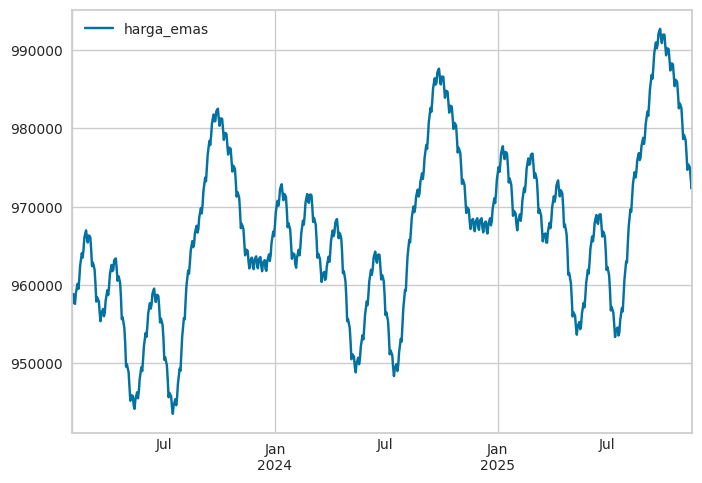

In [66]:
hasil_ts_uni_prophet =  pycaret_prophet.predict_model(model_pycaret_prophet,fh=730)
hasil_ts_uni_prophet.columns = ['harga_emas']
print(hasil_ts_uni_prophet)
hasil_ts_uni_prophet.plot()

In [67]:
model_pakai_ts = ['naive', 'grand_means', 'snaive', 'prophet', 'lr_cds_dt',
               'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'lar_cds_dt',
               'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'par_cds_dt', 
               'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt','et_cds_dt',
               'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 
               'catboost_cds_dt']

In [68]:
from datetime import date

tabel_emas_kurs_inflasi_interest_covid[tabel_emas_kurs_inflasi_interest_covid.tanggal==date(2010,2,26)]

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths


In [69]:
from sklearn.impute import KNNImputer
from pycaret.time_series import *

tabel_emas_pycaret = tabel_emas_kurs_inflasi_interest_covid.copy()
tabel_emas_pycaret.tanggal = pd.to_datetime(tabel_emas_pycaret.tanggal)
tabel_emas_pycaret.tanggal = tabel_emas_pycaret.tanggal.dt.to_period('B')
tabel_emas_pycaret = tabel_emas_pycaret.drop_duplicates('tanggal')
tabel_emas_pycaret = tabel_emas_pycaret.set_index('tanggal')

idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
knnimp = KNNImputer()

kol_tab_pyc = tabel_emas_pycaret.columns.tolist()
tabel_emas_pycaret = knnimp.fit_transform(tabel_emas_pycaret)
tabel_emas_pycaret = pd.DataFrame(tabel_emas_pycaret,columns=kol_tab_pyc)
tabel_emas_pycaret = tabel_emas_pycaret.set_index(idx)

print(tabel_emas_pycaret.isna().sum())

pycaret_time_series_all = TSForecastingExperiment()
pycaret_time_series_all.setup(data=tabel_emas_pycaret,session_id=42,
            target='harga_emas',
            numeric_imputation_target='drift',
            numeric_imputation_exogenous='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            transform_target="box-cox",
            transform_exogenous="box-cox",
            fold=2,
            fh=730)

pycaret_time_series_all.check_stats()

harga_emas       0
kurs_jual        0
kurs_beli        0
data_inflasi     0
suku_bunga_bi    0
new_cases        0
new_deaths       0
dtype: int64


,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(3412, 7)"
5,Transformed data shape,"(3412, 7)"
6,Transformed train set shape,"(2682, 7)"
7,Transformed test set shape,"(730, 7)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1.511228
3,Summary,Statistics,Transformed,Median,,1.511221
4,Summary,Statistics,Transformed,Standard Deviation,,0.000034
5,Summary,Statistics,Transformed,Variance,,0.0
6,Summary,Statistics,Transformed,Kurtosis,,-0.375511
7,Summary,Statistics,Transformed,Skewness,,0.02593
8,Summary,Statistics,Transformed,# Distinct Values,,556.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71874.317859


In [70]:
model_pycaret_all = pycaret_time_series_all.compare_models(include=model_pakai_ts,budget_time=10)
tuned_model_pycaret_all = pycaret_time_series_all.tune_model(model_pycaret_all,
                                      search_algorithm='random')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7310,0.8010,35203.9612,51003.4398,0.0490,0.0520,-0.0344,158.1850
naive,Naive Forecaster,0.8208,0.8993,42940.4848,60175.2278,0.0640,0.0673,-1.0456,0.3450
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8760,0.9077,45073.9219,60338.4527,0.0668,0.0674,-0.8988,149.7450
prophet,Prophet,1.0477,1.0586,53216.7344,69660.1445,0.0785,0.0803,-1.2661,1.7950
snaive,Seasonal Naive Forecaster,1.1624,1.1495,58271.5048,75399.9879,0.0849,0.0905,-1.5747,0.2800
grand_means,Grand Means Forecaster,1.8327,1.5713,90926.7398,102509.8811,0.1337,0.1468,-3.5438,0.2200


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-09-09,1.2062,1.0240,72148.2089,76718.7290,0.1225,0.1146,-5.3878
1,2017-06-27,0.9445,1.0806,43775.5042,66821.2500,0.0587,0.0612,-0.0842
Mean,NaT,1.0753,1.0523,57961.8566,71769.9895,0.0906,0.0879,-2.7360
SD,NaT,0.1309,0.0283,14186.3524,4948.7395,0.0319,0.0267,2.6518


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 36.2min finished


In [71]:
pycaret_time_series_all.plot_model(tuned_model_pycaret_all)

In [72]:
pycaret_time_series_all.plot_model(tuned_model_pycaret_all,plot="diagnostics")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [73]:
pycaret_time_series_all.plot_model(model_pycaret_all,plot="decomp_stl")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [74]:
final_model_pycaret_all = pycaret_time_series_all.finalize_model(model_pycaret_all)
final_model_pycaret_all

ForecastingPipeline(steps=[('transformer_exogenous',
                            TransformerPipeline(steps=[('numerical_imputer',
                                                        Imputer(random_state=42)),
                                                       ('transformer',
                                                        ColumnwiseTransformer(transformer=BoxCoxTransformer()))])),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42)),
                                                                                           ('transformer',
                                                                                            BoxCoxTransformer())])),
                                                               ('model',
                                                                BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [252,
                                                                                                                                        251,
                                                                                                                                        250,
                                                                                                                                        249,
                                                                                                                                        248,
                                                                                                                                        247,
                                                                                                                                        246,
                                                                                                                                        245,
                                                                                                                                        244,
                                                                                                                                        243,
                                                                                                                                        242,
                                                                                                                                        241,
                                                                                                                                        240,
                                                                                                                                        239,
                                                                                                                                        238,
                                                                                                                                        237,
                                                                                                                                        236,
                                                                                                                                        235,
                                                                                                                                        234,
                                                                                                                                        233,
                                                                                                                           

# Pycaret For Exogenous

In [75]:
kolom_exo = tabel_emas_pycaret.columns.tolist()
kolom_exo.remove('harga_emas')
kolom_exo

['kurs_jual',
 'kurs_beli',
 'data_inflasi',
 'suku_bunga_bi',
 'new_cases',
 'new_deaths']

In [76]:
kolom_exo = tabel_emas_pycaret.columns.tolist()
kolom_exo.remove('harga_emas')

exog_exps = []
exog_models = []
for exog_var in kolom_exo:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=tabel_emas_pycaret[exog_var], fh=730,
        numeric_imputation_target="drift", 
        session_id=42,
        transform_target="box-cox",
        max_sp_to_consider=None,
        num_sps_to_use=-1,
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    display(exog_exp.check_stats())
    best = exog_exp.compare_models(include=model_pakai_ts,sort="RMSE",budget_time=10)
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = kolom_exo
future_exog.head()

,Description,Value
0,session_id,42
1,Target,kurs_jual
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,563904696619.703491
3,Summary,Statistics,Transformed,Median,,629551769458.05835
4,Summary,Statistics,Transformed,Standard Deviation,,247037311131.220245
5,Summary,Statistics,Transformed,Variance,,61027433090943308267520.0
6,Summary,Statistics,Transformed,Kurtosis,,-1.132564
7,Summary,Statistics,Transformed,Skewness,,-0.257153
8,Summary,Statistics,Transformed,# Distinct Values,,2403.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71035.522958


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
snaive,Seasonal Naive Forecaster,19.9771,7.6320,7677.4634,7772.3593,0.6469,1.2044,-171.6477,0.1067
prophet,Prophet,20.1294,7.6839,7726.5104,7813.9342,0.6503,1.2080,-171.8935,1.7567
naive,Naive Forecaster,20.5127,7.8185,7849.9451,7921.6107,0.6591,1.2176,-172.6416,1.7933
grand_means,Grand Means Forecaster,nan,nan,nan,nan,nan,nan,nan,1.1400


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,kurs_beli
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,546597026379.771667
3,Summary,Statistics,Transformed,Median,,610098419523.724609
4,Summary,Statistics,Transformed,Standard Deviation,,239447891559.14267
5,Summary,Statistics,Transformed,Variance,,57335292772118947692544.0
6,Summary,Statistics,Transformed,Kurtosis,,-1.132558
7,Summary,Statistics,Transformed,Skewness,,-0.257135
8,Summary,Statistics,Transformed,# Distinct Values,,2395.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71035.472131


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
grand_means,Grand Means Forecaster,22.2086,8.4718,8320.6657,8370.4069,0.6989,1.2748,-182.7788,0.1067
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,11.9133
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.3667
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.2333
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.2300
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.5700
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.1567
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.1200
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,12.1000
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,nan,nan,nan,nan,nan,nan,nan,11.6667


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,data_inflasi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,-1.694361
3,Summary,Statistics,Transformed,Median,,-1.690348
4,Summary,Statistics,Transformed,Standard Deviation,,0.104053
5,Summary,Statistics,Transformed,Variance,,0.010827
6,Summary,Statistics,Transformed,Kurtosis,,-0.467316
7,Summary,Statistics,Transformed,Skewness,,-0.03407
8,Summary,Statistics,Transformed,# Distinct Values,,137.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71402.853469


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,2.9218,1.9634,0.0128,0.0153,0.2868,0.2681,-1.8869,15.8833
naive,Naive Forecaster,3.0531,2.2055,0.0133,0.0168,0.2799,0.2795,-2.4227,0.1067
grand_means,Grand Means Forecaster,3.5374,2.1865,0.0156,0.0172,0.3805,0.3273,-5.9143,0.1100
snaive,Seasonal Naive Forecaster,3.1157,2.2687,0.0136,0.0174,0.2823,0.2858,-2.7249,0.1067
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,3.5435,2.1719,0.0157,0.0176,0.3986,0.3172,-3.3506,15.0367
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,3.5435,2.1719,0.0157,0.0176,0.3986,0.3172,-3.3506,15.4600
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,3.5421,2.1724,0.0157,0.0176,0.3985,0.3171,-3.3523,14.8400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,3.7670,2.2698,0.0166,0.0183,0.4217,0.3339,-3.4146,14.7067
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,3.8084,2.3553,0.0167,0.0189,0.4345,0.3331,-3.2569,15.4533
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,3.8085,2.3574,0.0167,0.0189,0.4355,0.3331,-3.2610,14.8067


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,suku_bunga_bi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,5.228312
3,Summary,Statistics,Transformed,Median,,5.343865
4,Summary,Statistics,Transformed,Standard Deviation,,1.548265
5,Summary,Statistics,Transformed,Variance,,2.397124
6,Summary,Statistics,Transformed,Kurtosis,,-1.079608
7,Summary,Statistics,Transformed,Skewness,,-0.101075
8,Summary,Statistics,Transformed,# Distinct Values,,18.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",73556.843708


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
snaive,Seasonal Naive Forecaster,1.7128,1.5429,0.8637,1.0803,0.1561,0.1436,-0.4590,0.1100
naive,Naive Forecaster,1.5238,1.5652,0.8072,1.1011,0.1510,0.1347,-0.5143,0.1167
grand_means,Grand Means Forecaster,1.9671,1.5673,1.0994,1.1828,0.2012,0.1822,-1.4414,0.1100


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,new_cases
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,13369325859505571157921961100563185664.0
3,Summary,Statistics,Transformed,Median,,-0.118034
4,Summary,Statistics,Transformed,Standard Deviation,,215915242848611120829965775779322134528.0
5,Summary,Statistics,Transformed,Variance,,4661939209437471176978305801434646374710814129...
6,Summary,Statistics,Transformed,Kurtosis,,574.673318
7,Summary,Statistics,Transformed,Skewness,,22.333573
8,Summary,Statistics,Transformed,# Distinct Values,,694.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",6980.775575


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
snaive,Seasonal Naive Forecaster,2.1843,1.2514,359.3127,633.3279,1251881574100194560.0000,0.4765,-3.4924,1.4133
naive,Naive Forecaster,3.2863,1.4583,538.5276,736.5061,2088566244227460608.0000,0.7028,-5.7526,0.1400
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,6.0480,2.0468,1028.5111,1044.0512,4447304953428809728.0000,1.9050,-8.4035,17.4367
grand_means,Grand Means Forecaster,6.1457,2.0786,1054.3245,1065.0844,4585300338746244608.0000,1.9022,-8.3645,0.1133
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,6.3063,2.1372,1082.8734,1095.6489,4722880394088382464.0000,1.9005,-8.9240,9.5200
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,6.3055,2.1373,1082.7466,1095.6936,4723395950694317056.0000,1.9003,-8.9247,9.8200
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,6.3055,2.1373,1082.7466,1095.6936,4723395950694317056.0000,1.9003,-8.9247,9.4800
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,6.3055,2.1373,1082.7466,1095.6936,4723395950694317056.0000,1.9003,-8.9247,9.3867
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,6.3055,2.1373,1082.7466,1095.6936,4723395950694317056.0000,1.9003,-8.9247,9.2533
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,6.3055,2.1373,1082.7466,1095.6936,4723395950694317056.0000,1.9003,-8.9247,9.6933


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,new_deaths
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1969687340145182081286144.0
3,Summary,Statistics,Transformed,Median,,-0.118034
4,Summary,Statistics,Transformed,Standard Deviation,,39592054535362108643606528.0
5,Summary,Statistics,Transformed,Variance,,1567530782331087012951348060035732481258606309...
6,Summary,Statistics,Transformed,Kurtosis,,957.50057
7,Summary,Statistics,Transformed,Skewness,,29.078918
8,Summary,Statistics,Transformed,# Distinct Values,,287.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",4067.683432


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,3.7677,1.5641,12.1170,16.6218,47654545552703880.0000,0.6968,-4.9146,0.1067
snaive,Seasonal Naive Forecaster,3.7677,1.5641,12.1170,16.6218,47654545552703880.0000,0.6968,-4.9146,0.1100
grand_means,Grand Means Forecaster,7.1389,2.2399,23.8161,24.0844,104093911826304336.0000,1.8956,-7.9397,0.1067
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,7.1775,2.2536,23.7799,24.1455,103883946935043952.0000,1.8960,-7.8102,16.0400
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,7.3102,2.2995,24.4058,24.7347,107003828697596848.0000,1.8935,-8.4690,8.2367
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,7.3217,2.3021,24.4451,24.7634,107150613859236288.0000,1.8937,-8.4938,8.0567
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,7.3217,2.3022,24.4450,24.7644,107156425954657264.0000,1.8936,-8.4943,7.9933
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,7.3217,2.3022,24.4450,24.7644,107156425954657264.0000,1.8936,-8.4943,7.6233
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,7.3217,2.3022,24.4450,24.7644,107156425954657264.0000,1.8936,-8.4943,7.9600
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,7.3217,2.3022,24.4450,24.7644,107156425954657264.0000,1.8936,-8.4943,7.7300


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
2023-02-01,15229.770,12753.3988,0.0530,3.5,274.0,4.0
2023-02-02,15212.680,12753.3988,0.0527,3.5,322.0,4.0
2023-02-03,15188.570,12753.3988,0.0528,3.5,211.0,4.0
2023-02-06,15430.568,12753.3988,0.0529,3.5,199.0,4.0
2023-02-07,15196.600,12753.3988,0.0519,3.5,260.0,4.0


<AxesSubplot: >

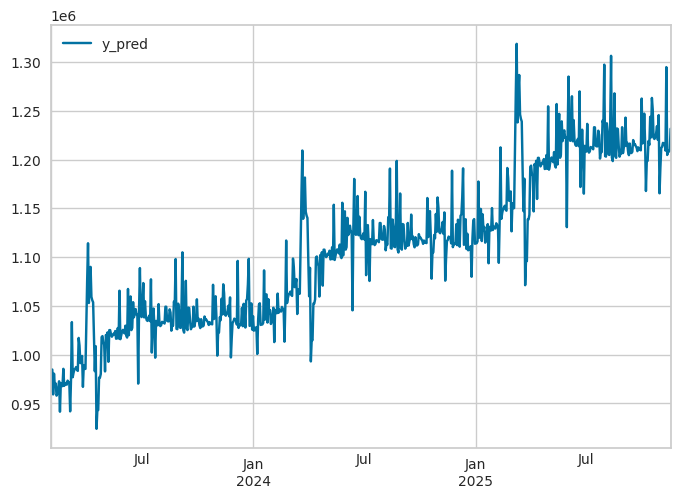

In [77]:
hasil_ts_all = pycaret_time_series_all.predict_model(final_model_pycaret_all,X=future_exog,fh=730,)
hasil_ts_all.plot()

In [78]:
from pycaret.time_series import *

tabel_emas_pycaret = tabel_emas_kurs_inflasi_interest_covid.copy()
tabel_emas_pycaret.tanggal = pd.to_datetime(tabel_emas_pycaret.tanggal)
tabel_emas_pycaret.tanggal = tabel_emas_pycaret.tanggal.dt.to_period('B')
tabel_emas_pycaret = tabel_emas_pycaret.drop_duplicates('tanggal')
tabel_emas_pycaret = tabel_emas_pycaret.set_index('tanggal')

idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
knnimp = KNNImputer()

kol_tab_pyc = tabel_emas_pycaret.columns.tolist()
tabel_emas_pycaret = knnimp.fit_transform(tabel_emas_pycaret)
tabel_emas_pycaret = pd.DataFrame(tabel_emas_pycaret,columns=kol_tab_pyc)
tabel_emas_pycaret = tabel_emas_pycaret.set_index(idx)

print(100*'=')
display(tabel_emas_pycaret.describe())
display(tabel_emas_pycaret.head())

pycaret_time_series_all_prophet = TSForecastingExperiment()
pycaret_time_series_all_prophet.setup(data=tabel_emas_pycaret,session_id=42,
            target='harga_emas',
            numeric_imputation_target='drift',
            numeric_imputation_exogenous='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            transform_target="box-cox",
            transform_exogenous="box-cox",
            fold=2,
            fh=730)


pycaret_time_series_all_prophet.check_stats()

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
count,3.412000e+03,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000
mean,6.689461e+05,12535.562970,12410.791949,0.042967,5.637697,1529.552948,34.638777
std,1.696623e+05,2161.440155,2139.940272,0.018147,1.296796,5841.243988,152.991747
min,3.940000e+05,8502.000000,8418.000000,0.013200,3.500000,0.000000,0.000000
25%,5.630000e+05,9974.750000,9874.750000,0.031600,4.750000,0.000000,0.000000
50%,6.100000e+05,13367.500000,13233.500000,0.041500,5.750000,0.000000,0.000000
75%,7.600000e+05,14302.160000,14160.000000,0.055100,6.750000,261.500000,5.000000
max,1.065000e+06,16824.710000,16657.300000,0.087900,7.750000,64718.000000,2069.000000


,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
2010-01-04,408000.0,9377.0,9283.0,0.0372,6.5,0.0,0.0
2010-01-05,410000.0,9355.0,9261.0,0.0372,6.5,0.0,0.0
2010-01-06,410000.0,9355.0,9261.0,0.0372,6.5,0.0,0.0
2010-01-07,412000.0,9274.0,9182.0,0.0372,6.5,0.0,0.0
2010-01-08,410000.0,9286.0,9194.0,0.0372,6.5,0.0,0.0


,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(3412, 7)"
5,Transformed data shape,"(3412, 7)"
6,Transformed train set shape,"(2682, 7)"
7,Transformed test set shape,"(730, 7)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1.511228
3,Summary,Statistics,Transformed,Median,,1.511221
4,Summary,Statistics,Transformed,Standard Deviation,,0.000034
5,Summary,Statistics,Transformed,Variance,,0.0
6,Summary,Statistics,Transformed,Kurtosis,,-0.375511
7,Summary,Statistics,Transformed,Skewness,,0.02593
8,Summary,Statistics,Transformed,# Distinct Values,,556.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71874.317859


In [79]:
model_pycaret_all_prophet =  pycaret_time_series_all_prophet.create_model('prophet')
model_pycaret_all_prophet

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-09-09,0.6915,0.6422,41359.9374,48114.4943,0.0694,0.0664,-1.5125
1,2017-06-27,1.4040,1.4749,65073.5315,91205.7947,0.0875,0.0942,-1.0198
Mean,NaT,1.0477,1.0586,53216.7344,69660.1445,0.0785,0.0803,-1.2661
SD,NaT,0.3563,0.4164,11856.7970,21545.6502,0.0091,0.0139,0.2463


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ProphetPeriodPatched()

In [80]:
tuned_model_pycaret_all_prophet =  pycaret_time_series_all_prophet.tune_model(model_pycaret_all_prophet)
tuned_model_pycaret_all_prophet

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-09-09,0.2997,0.2868,17929.3371,21489.6178,0.0304,0.0304,0.4988
1,2017-06-27,1.5115,1.5569,70059.4042,96274.3589,0.0945,0.1021,-1.2506
Mean,NaT,0.9056,0.9219,43994.3707,58881.9883,0.0625,0.0663,-0.3759
SD,NaT,0.6059,0.6350,26065.0335,37392.3706,0.0320,0.0359,0.8747


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.3s finished


ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                     holidays_prior_scale=0.01095960453692584,
                     seasonality_prior_scale=7.886714129990491)

In [81]:
pycaret_time_series_all_prophet.plot_model(tuned_model_pycaret_all_prophet)

In [82]:
final_tuned_model_pycaret_all_prophet =  pycaret_time_series_all_prophet.finalize_model(tuned_model_pycaret_all_prophet)
final_tuned_model_pycaret_all_prophet

ForecastingPipeline(steps=[('transformer_exogenous',
                            TransformerPipeline(steps=[('numerical_imputer',
                                                        Imputer(random_state=42)),
                                                       ('transformer',
                                                        ColumnwiseTransformer(transformer=BoxCoxTransformer()))])),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42)),
                                                                                           ('transformer',
                                                                                            BoxCoxTransformer())])),
                                                               ('model',
                                                                ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                                                                                     holidays_prior_scale=0.01095960453692584,
                                                                                     seasonality_prior_scale=7.886714129990491))]))])

## Pycaret All prophet

In [83]:
kolom_exo = tabel_emas_pycaret.columns.tolist()
kolom_exo.remove('harga_emas')

exog_exps = []
exog_models = []
for exog_var in kolom_exo:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=tabel_emas_pycaret[exog_var], fh=730,
        numeric_imputation_target="drift", 
        session_id=42,
        transform_target="box-cox",
        max_sp_to_consider=None,
        num_sps_to_use=-1,
    )
    print(exog_exp.check_stats())

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.create_model("prophet")
    best = exog_exp.tune_model(best)
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)
    display(exog_exp.check_stats())
    
    
    
# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = kolom_exo
future_exog.head()

,Description,Value
0,session_id,42
1,Target,kurs_jual
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


            Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,25.0696,9.1843,10491.1491,10557.3862,0.9975,1.9900,-78.9447
1,2014-09-09,31.7230,12.1916,11530.5005,11543.7897,0.8730,1.5492,-433.5791
2,2017-06-27,3.5957,1.6759,1157.8816,1340.6267,0.0805,0.0849,-3.1565
Mean,NaT,20.1294,7.6839,7726.5104,7813.9342,0.6503,1.2080,-171.8935
SD,NaT,12.0025,4.4222,4664.0631,4594.9995,0.4061,0.8143,187.6086


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,25.0696,9.1843,10491.1491,10557.3862,0.9975,1.9900,-78.9447
1,2014-09-09,31.7230,12.1916,11530.5005,11543.7897,0.8730,1.5492,-433.5791
2,2017-06-27,1.5736,0.8556,506.7418,684.4623,0.0357,0.0361,-0.0835
Mean,NaT,19.4554,7.4105,7509.4638,7595.2127,0.6354,1.1918,-170.8691
SD,NaT,12.9328,4.7948,4969.8189,4903.2032,0.4271,0.8368,188.5333


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.0s finished


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,563904696619.703491
3,Summary,Statistics,Transformed,Median,,629551769458.05835
4,Summary,Statistics,Transformed,Standard Deviation,,247037311131.220245
5,Summary,Statistics,Transformed,Variance,,61027433090943308267520.0
6,Summary,Statistics,Transformed,Kurtosis,,-1.132564
7,Summary,Statistics,Transformed,Skewness,,-0.257153
8,Summary,Statistics,Transformed,# Distinct Values,,2403.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71035.522958


,Description,Value
0,session_id,42
1,Target,kurs_beli
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


            Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,nan,nan,nan,nan,nan,nan,nan
1,2014-09-09,31.6605,12.1681,11393.7622,11406.9454,0.8713,1.5439,-431.8808
2,2017-06-27,3.5639,1.6628,1136.3062,1316.9230,0.0798,0.0841,-3.0908
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,nan,nan,nan,nan,nan,nan,nan
1,2014-09-09,31.6605,12.1681,11393.7622,11406.9454,0.8713,1.5439,-431.8808
2,2017-06-27,3.2198,1.5211,1026.5800,1204.7303,0.0721,0.0756,-2.4235
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.0s finished


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,546597026379.771667
3,Summary,Statistics,Transformed,Median,,610098419523.724609
4,Summary,Statistics,Transformed,Standard Deviation,,239447891559.14267
5,Summary,Statistics,Transformed,Variance,,57335292772118947692544.0
6,Summary,Statistics,Transformed,Kurtosis,,-1.132558
7,Summary,Statistics,Transformed,Skewness,,-0.257135
8,Summary,Statistics,Transformed,# Distinct Values,,2395.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71035.472131


,Description,Value
0,session_id,42
1,Target,data_inflasi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


            Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,9.3140,7.0035,0.0378,0.0456,0.5999,0.9837,-6.0432
1,2014-09-09,4.4371,2.5705,0.0200,0.0231,0.3884,0.4989,-1.1519
2,2017-06-27,0.7158,0.5121,0.0033,0.0045,0.0976,0.1041,-0.1602
Mean,NaT,4.8223,3.3620,0.0204,0.0244,0.3620,0.5289,-2.4517
SD,NaT,3.5207,2.7085,0.0141,0.0168,0.2059,0.3597,2.5716


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,6.3250,5.0901,0.0257,0.0332,0.3931,0.5376,-2.7205
1,2014-09-09,5.6961,3.4126,0.0257,0.0307,0.6855,0.4522,-2.7927
2,2017-06-27,2.2997,1.2904,0.0107,0.0112,0.3466,0.2891,-6.3669
Mean,NaT,4.7736,3.2644,0.0207,0.0250,0.4751,0.4263,-3.9600
SD,NaT,1.7680,1.5548,0.0071,0.0098,0.1500,0.1031,1.7022


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.1s finished


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,-1.694361
3,Summary,Statistics,Transformed,Median,,-1.690348
4,Summary,Statistics,Transformed,Standard Deviation,,0.104053
5,Summary,Statistics,Transformed,Variance,,0.010827
6,Summary,Statistics,Transformed,Kurtosis,,-0.467316
7,Summary,Statistics,Transformed,Skewness,,-0.03407
8,Summary,Statistics,Transformed,# Distinct Values,,137.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",71402.853469


,Description,Value
0,session_id,42
1,Target,suku_bunga_bi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


            Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,nan,nan,nan,nan,nan,nan,nan
1,2014-09-09,1.4406,1.5411,1.0697,1.4770,0.2056,0.1699,-0.5135
2,2017-06-27,nan,nan,nan,nan,nan,nan,nan
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,2.8333,2.2268,0.8105,0.8457,0.1322,0.1252,-0.1319
1,2014-09-09,2.7975,2.8706,2.0771,2.7513,0.3932,0.2868,-4.2513
2,2017-06-27,1.4485,1.2084,1.2438,1.4227,0.2639,0.2231,-3.5633
Mean,NaT,2.3597,2.1019,1.3772,1.6732,0.2631,0.2117,-2.6488
SD,NaT,0.6445,0.6843,0.5256,0.7978,0.1065,0.0665,1.8018


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.9s finished


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,5.228312
3,Summary,Statistics,Transformed,Median,,5.343865
4,Summary,Statistics,Transformed,Standard Deviation,,1.548265
5,Summary,Statistics,Transformed,Variance,,2.397124
6,Summary,Statistics,Transformed,Kurtosis,,-1.079608
7,Summary,Statistics,Transformed,Skewness,,-0.101075
8,Summary,Statistics,Transformed,# Distinct Values,,18.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",73556.843708


,Description,Value
0,session_id,42
1,Target,new_cases
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


            Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,6.4098,2.1679,1087.1107,1104.1812,4779860730717854720.0000,1.8851,-7.3225
1,2014-09-09,nan,nan,nan,nan,nan,nan,nan
2,2017-06-27,nan,nan,nan,nan,nan,nan,nan
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,6.5111,2.2027,1104.2914,1121.8835,4861837646480994304.0000,1.8842,-7.5915
1,2014-09-09,5.9169,2.0687,1085.7217,1095.9614,4803641406240432128.0000,1.9213,-10.5616
2,2017-06-27,6.5114,2.1464,1058.8701,1070.4864,4507496075898144768.0000,1.8954,-8.4485
Mean,NaT,6.3131,2.1393,1082.9611,1096.1104,4724325042873190400.0000,1.9003,-8.8672
SD,NaT,0.2802,0.0549,18.6456,20.9831,155151111896613824.0000,0.0155,1.2482


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.6s finished


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,13369325859505571157921961100563185664.0
3,Summary,Statistics,Transformed,Median,,-0.118034
4,Summary,Statistics,Transformed,Standard Deviation,,215915242848611120829965775779322134528.0
5,Summary,Statistics,Transformed,Variance,,4661939209437471176978305801434646374710814129...
6,Summary,Statistics,Transformed,Kurtosis,,574.673318
7,Summary,Statistics,Transformed,Skewness,,22.333573
8,Summary,Statistics,Transformed,# Distinct Values,,694.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",6980.775575


,Description,Value
0,session_id,42
1,Target,new_deaths
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3412, 1)"
5,Transformed data shape,"(3412, 1)"
6,Transformed train set shape,"(2682, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


            Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,7.5714,2.3563,24.6207,25.0074,108254294930819712.0000,1.8851,-7.3237
1,2014-09-09,nan,nan,nan,nan,nan,nan,nan
2,2017-06-27,nan,nan,nan,nan,nan,nan,nan
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2011-11-22,7.6906,2.3939,25.0082,25.4066,110102832441977248.0000,1.8842,-7.5915
1,2014-09-09,6.8730,2.2296,24.5876,24.8195,108784910406771968.0000,1.9213,-10.5616
2,2017-06-27,7.4423,2.2931,23.7962,24.1330,102827668207182368.0000,1.8756,-7.1487
Mean,NaT,7.3353,2.3055,24.4640,24.7864,107238470351977200.0000,1.8937,-8.4340
SD,NaT,0.3423,0.0676,0.5024,0.5204,3164976176120434.5000,0.0198,1.5153


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.9s finished


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3412.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1969687340145182081286144.0
3,Summary,Statistics,Transformed,Median,,-0.118034
4,Summary,Statistics,Transformed,Standard Deviation,,39592054535362108643606528.0
5,Summary,Statistics,Transformed,Variance,,1567530782331087012951348060035732481258606309...
6,Summary,Statistics,Transformed,Kurtosis,,957.50057
7,Summary,Statistics,Transformed,Skewness,,29.078918
8,Summary,Statistics,Transformed,# Distinct Values,,287.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",4067.683432


,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
2023-02-01,14979.2574,14740.7366,0.0223,4.1595,39662.2311,1132.6164
2023-02-02,14993.0443,14751.9487,0.0220,4.1311,40037.8073,1139.9772
2023-02-03,14970.7912,14752.2769,0.0221,4.1385,40234.6315,1129.6744
2023-02-06,14912.7784,14694.3014,0.0218,4.1195,41740.9372,1123.8496
2023-02-07,14916.5232,14707.6850,0.0218,4.1082,42138.0827,1167.0164


In [84]:
forecast_df_all_prophet = pycaret_time_series_all.predict_model(final_model_pycaret_all,X=future_exog,fh=730,)
forecast_df_all_prophet

,y_pred
2023-02-01,9.639619e+05
2023-02-02,9.871381e+05
2023-02-03,9.869981e+05
2023-02-06,9.621839e+05
2023-02-07,9.838957e+05
...,...
2025-11-12,1.209685e+06
2025-11-13,1.214410e+06
2025-11-14,1.212832e+06
2025-11-17,1.213734e+06


<AxesSubplot: >

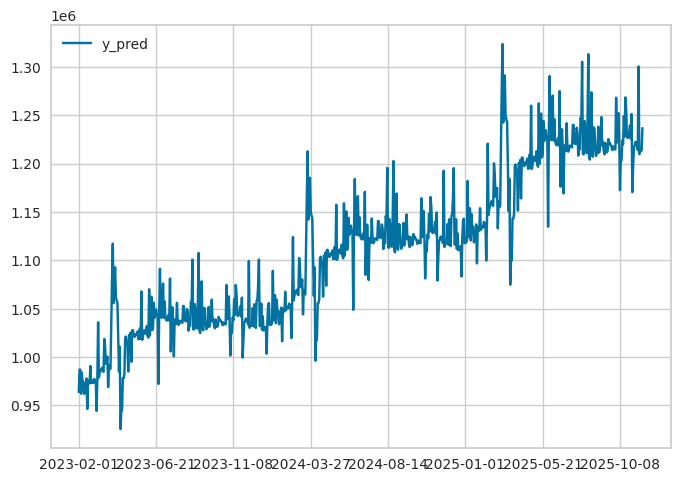

In [85]:
forecast_df_all_prophet.index = forecast_df_all_prophet.index.strftime('%Y-%m-%d')
forecast_df_all_prophet.plot()

In [86]:
forecast_df_all_prophet.columns = ['harga_emas']
forecast_df_all_prophet

,harga_emas
2023-02-01,9.639619e+05
2023-02-02,9.871381e+05
2023-02-03,9.869981e+05
2023-02-06,9.621839e+05
2023-02-07,9.838957e+05
...,...
2025-11-12,1.209685e+06
2025-11-13,1.214410e+06
2025-11-14,1.212832e+06
2025-11-17,1.213734e+06


In [87]:
future_exog.index = future_exog.index.strftime('%Y-%m-%d')
future_exog.index

Index(['2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
       '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14',
       ...
       '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-10', '2025-11-11',
       '2025-11-12', '2025-11-13', '2025-11-14', '2025-11-17', '2025-11-18'],
      dtype='object', length=730)

In [88]:
hasil_forecast_all_prophet = pd.merge(forecast_df_all_prophet, future_exog, left_index=True, right_index=True)
hasil_forecast_all_prophet

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
2023-02-01,9.639619e+05,14979.2574,14740.7366,0.0223,4.1595,39662.2311,1132.6164
2023-02-02,9.871381e+05,14993.0443,14751.9487,0.0220,4.1311,40037.8073,1139.9772
2023-02-03,9.869981e+05,14970.7912,14752.2769,0.0221,4.1385,40234.6315,1129.6744
2023-02-06,9.621839e+05,14912.7784,14694.3014,0.0218,4.1195,41740.9372,1123.8496
2023-02-07,9.838957e+05,14916.5232,14707.6850,0.0218,4.1082,42138.0827,1167.0164
...,...,...,...,...,...,...,...
2025-11-12,1.209685e+06,15916.4840,15405.2823,0.0189,4.5657,42384.7633,1178.8175
2025-11-13,1.214410e+06,15942.4049,15422.6872,0.0187,4.5486,42279.4458,1186.7376
2025-11-14,1.212832e+06,15932.2392,15430.3517,0.0188,4.5663,42035.9624,1182.0193
2025-11-17,1.213734e+06,15909.5496,15399.5239,0.0188,4.5748,42032.3770,1187.2692


<AxesSubplot: >

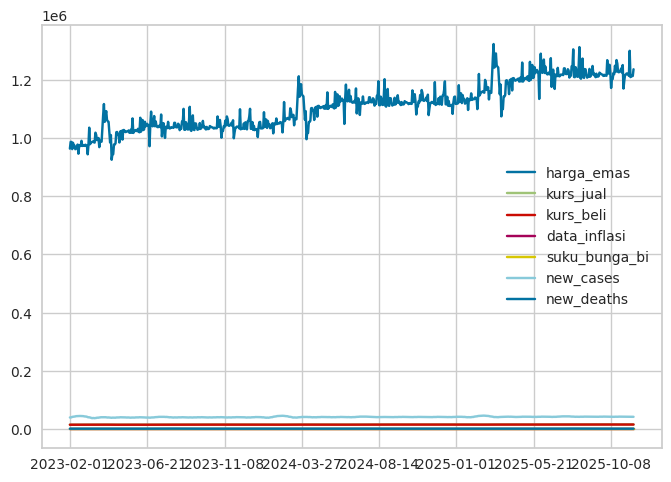

In [89]:
hasil_forecast_all_prophet.plot()

In [90]:
hasil_forecast_all_prophet.index = pd.PeriodIndex(hasil_forecast_all_prophet.index,freq='B')
hasil_forecast_all_prophet

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
2023-02-01,9.639619e+05,14979.2574,14740.7366,0.0223,4.1595,39662.2311,1132.6164
2023-02-02,9.871381e+05,14993.0443,14751.9487,0.0220,4.1311,40037.8073,1139.9772
2023-02-03,9.869981e+05,14970.7912,14752.2769,0.0221,4.1385,40234.6315,1129.6744
2023-02-06,9.621839e+05,14912.7784,14694.3014,0.0218,4.1195,41740.9372,1123.8496
2023-02-07,9.838957e+05,14916.5232,14707.6850,0.0218,4.1082,42138.0827,1167.0164
...,...,...,...,...,...,...,...
2025-11-12,1.209685e+06,15916.4840,15405.2823,0.0189,4.5657,42384.7633,1178.8175
2025-11-13,1.214410e+06,15942.4049,15422.6872,0.0187,4.5486,42279.4458,1186.7376
2025-11-14,1.212832e+06,15932.2392,15430.3517,0.0188,4.5663,42035.9624,1182.0193
2025-11-17,1.213734e+06,15909.5496,15399.5239,0.0188,4.5748,42032.3770,1187.2692


<AxesSubplot: >

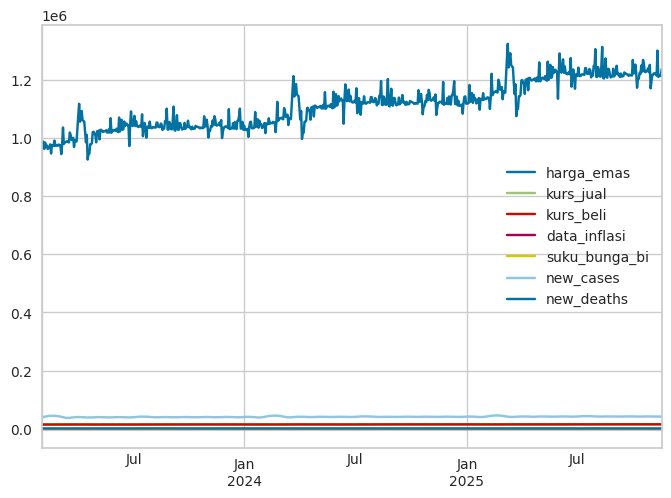

In [91]:
hasil_forecast_all_prophet.plot()

In [92]:
hasil_tabel_emas_pycaret_all_prophet = pd.concat([tabel_emas_pycaret,hasil_forecast_all_prophet])
hasil_tabel_emas_pycaret_all_prophet

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi,new_cases,new_deaths
2010-01-04,4.080000e+05,9377.0000,9283.0000,0.0372,6.5000,0.0000,0.0000
2010-01-05,4.100000e+05,9355.0000,9261.0000,0.0372,6.5000,0.0000,0.0000
2010-01-06,4.100000e+05,9355.0000,9261.0000,0.0372,6.5000,0.0000,0.0000
2010-01-07,4.120000e+05,9274.0000,9182.0000,0.0372,6.5000,0.0000,0.0000
2010-01-08,4.100000e+05,9286.0000,9194.0000,0.0372,6.5000,0.0000,0.0000
...,...,...,...,...,...,...,...
2025-11-12,1.209685e+06,15916.4840,15405.2823,0.0189,4.5657,42384.7633,1178.8175
2025-11-13,1.214410e+06,15942.4049,15422.6872,0.0187,4.5486,42279.4458,1186.7376
2025-11-14,1.212832e+06,15932.2392,15430.3517,0.0188,4.5663,42035.9624,1182.0193
2025-11-17,1.213734e+06,15909.5496,15399.5239,0.0188,4.5748,42032.3770,1187.2692


<AxesSubplot: >

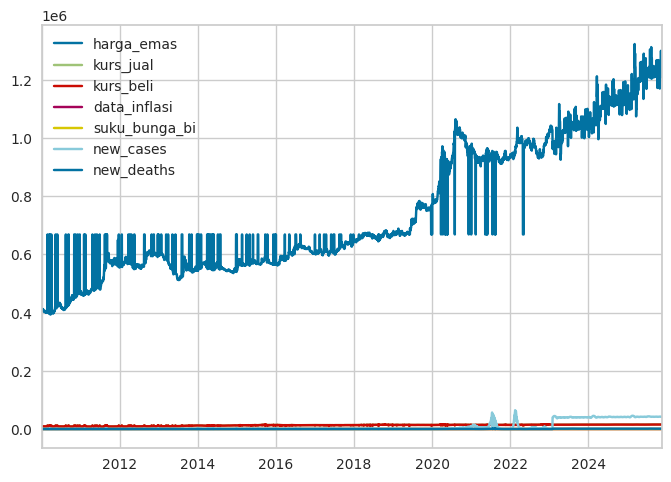

In [93]:
hasil_tabel_emas_pycaret_all_prophet.plot()

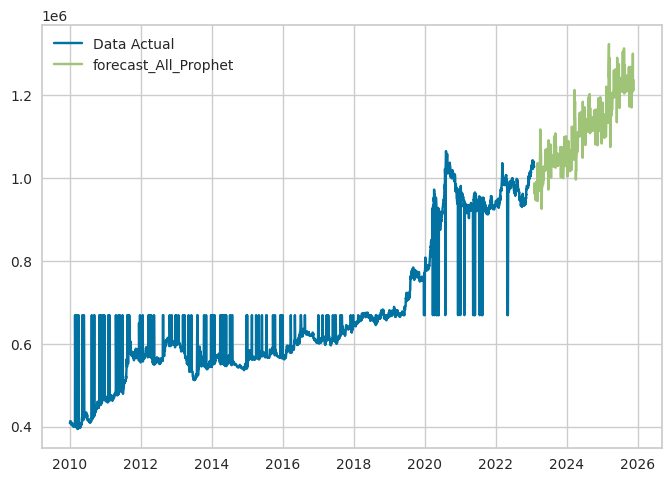

In [94]:
plt.plot(tabel_emas_pycaret.index.to_timestamp(),tabel_emas_pycaret.harga_emas,label="Data Actual")
plt.plot(hasil_forecast_all_prophet.index.to_timestamp(),hasil_forecast_all_prophet.harga_emas,label="forecast_All_Prophet")
plt.legend()
plt.show()